## DATA301 Individual Project

Question: How much perfomance in prediction do I lose when I predict anemia using variables that are easier to measure and less invasive with respect to predictions based on blood tests?

In [1]:
import pandas as pd
import numpy as np
import xport
import sklearn
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import f_regression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV  
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

In [2]:
# function to filter out columns and rows with too many NAs, threshold is 40% NAs in either the column or the row:
def naFilter(dataset):
    for i in dataset:
        if dataset[i].isna().sum()/len(dataset) > 0.5:
            dataset = dataset.drop(i, axis='columns')
    for i in range(len(dataset)):
        if dataset.loc[i].isna().sum()/len(dataset.loc[i]) > 0.5:
            dataset = dataset.drop(i)
    return dataset

# function to extract categorical and numerical column names
def catNamesAndNumNames(dataset):
    catNames = []
    numNames = []
    for i in dataset:
        if i == 'Anemia':
            pass
        elif len(pd.unique(dataset[i])) < 11:
                catNames.append(i)
        else:
            numNames.append(i)
    return catNames, numNames

In [3]:
combinedLabDataImputed = pd.read_csv('combinedLabData.csv')
combinedDemoEnvDataFinalTest = pd.read_csv('combined_data_imputed_final_test.csv')

In [15]:
anemiaInv = []
for i in range(len(combinedDemoEnvDataFinalTest)):
    if combinedDemoEnvDataFinalTest['DMDHRGND'][i] == 1 and combinedDemoEnvDataFinalTest['LBXHGB'][i] < 13:
        anemiaInv.append('True')
    elif combinedDemoEnvDataFinalTest['DMDHRGND'][i] == 2 and combinedDemoEnvDataFinalTest['LBXHGB'][i] < 12:
        anemiaInv.append('True')
    else:
        anemiaInv.append('False')

combinedDemoEnvDataFinalTest['Anemia'] = anemiaInv

In [16]:
anemiaDemoEnv = []
for i in range(len(combinedLabDataImputed)):
    if combinedLabDataImputed['DMDHRGND'][i] == 1 and combinedLabDataImputed['LBXHGB'][i] < 13:
        anemiaDemoEnv.append('True')
    elif combinedLabDataImputed['DMDHRGND'][i] == 2 and combinedLabDataImputed['LBXHGB'][i] < 12:
        anemiaDemoEnv.append('True')
    else:
        anemiaDemoEnv.append('False')

combinedLabDataImputed['Anemia'] = anemiaDemoEnv

In [4]:
combinedDemoEnvDataFinalTest['SEQN'] = combinedDemoEnvDataFinalTest['SEQN.1']
combinedDemoEnvDataFinalTest = combinedDemoEnvDataFinalTest.drop(['SEQN.1'], axis = 1)

In [5]:
newDataset =  pd.merge(combinedLabDataImputed, combinedDemoEnvDataFinalTest.drop(['DMDHRGND', 'LBXHGB'], axis =1), on='SEQN', how='left')

In [6]:
num, cat = catNamesAndNumNames(newDataset)
numdata = newDataset[num]
catdata = newDataset[cat]

In [7]:
# Create an imputer object 
imputer_num = SimpleImputer(missing_values=np.nan, strategy='median')
imputer_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# Apply the imputer to the numerical data
numdataimputed = pd.DataFrame(imputer_num.fit_transform(numdata), columns=numdata.columns)

# Impute missing values with the mode for each column
catdataimputed = pd.DataFrame(imputer_cat.fit_transform(catdata), columns=catdata.columns)

In [8]:
newDataset = pd.concat([numdataimputed, catdataimputed], axis = 1)

In [9]:
seqn = newDataset['SEQN']
newDataset.pop('SEQN')
newDataset.insert(0, 'SEQN', seqn)
newDataset

,SEQN,LBDBANO_x,DMDHRGND,LBDBPBLC,LBDBCDLC,LBDTHGLC,LBDBSELC,LBDBMNLC,LBDIHGLC,LBDBGELC,...,LBDSUASI,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,BMXSAD1,BMXSAD2
0,86094.0,1.000000e-01,1.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.0,...,523.4,81.3,168.0,28.8,40.1,36.5,36.4,93.7,21.7,22.1
1,99804.0,1.000000e-01,2.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.0,...,315.2,77.1,165.7,28.0,39.0,37.0,32.5,97.2,21.7,21.6
2,94012.0,1.000000e-01,2.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.0,...,511.5,92.5,170.5,31.8,38.0,39.2,34.5,110.0,21.7,21.6
3,94467.0,5.397605e-79,1.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.0,...,315.2,77.1,165.7,28.0,39.0,37.0,32.5,97.2,21.7,21.6
4,89039.0,1.000000e-01,2.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.0,...,315.2,77.1,165.7,28.0,39.0,37.0,32.5,97.2,21.7,21.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,86077.0,5.397605e-79,2.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.0,...,267.7,69.8,149.9,31.1,34.2,33.5,28.2,100.0,23.4,24.0
2496,97412.0,1.000000e-01,1.0,5.397605e-79,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,1.0,1.0,...,315.2,77.1,165.7,28.0,39.0,37.0,32.5,97.2,21.7,21.6
2497,100824.0,5.397605e-79,2.0,5.397605e-79,1.000000e+00,1.000000e+00,5.397605e-79,5.397605e-79,1.0,1.0,...,315.2,77.1,165.7,28.0,39.0,37.0,32.5,97.2,21.7,21.6
2498,101166.0,1.000000e-01,1.0,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.0,...,339.0,96.6,171.5,32.8,45.0,40.0,41.3,94.9,21.7,21.6


In order to measure performance of our models, we will compare the models using the following performance metrics to look at how much info is gained/lost when using external factors compared to blood test info: AUC/ROC, Accuracy, Precision and Sensitivity.

In [13]:
anemia = []
for i in range(len(newDataset)):
    if newDataset['DMDHRGND'][i] == 1 and newDataset['LBXHGB'][i] < 13:
        anemia.append('True')
    elif newDataset['DMDHRGND'][i] == 2 and newDataset['LBXHGB'][i] < 12:
        anemia.append('True')
    else:
        anemia.append('False')

newDataset['Anemia'] = anemia

In order to answer our question, I will look at the performances of the models using the invasive dataset, the demographic/environmental dataset and a combination of both .

## Invasive data models:

In [17]:
catVars, numVars = catNamesAndNumNames(combinedLabDataImputed.drop(['SEQN','LBXHGB','DMDHRGND','Anemia'], axis=1))
xtrain, xtest, ytrain, ytest = train_test_split(combinedLabDataImputed.drop(['SEQN','LBXHGB','DMDHRGND','Anemia'], axis=1), anemia, test_size=0.2, random_state=42)
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent"))]
)
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler(with_mean=False))]
)
preprocessor = ColumnTransformer( 
    transformers=[
        ("num", numeric_transformer, numVars),
        ("cat", categorical_transformer, catVars)]
)

# 10% of the total variables will be selected
selection = SelectPercentile(chi2, percentile = 10)
pipe1 = Pipeline(
    steps = [("preprocessor", preprocessor),  ("rfc", RandomForestClassifier())]
)

random_grid = {'rfc__n_estimators': [200, 400, 600, 800, 1000],
               'rfc__max_features': ['log2', 'sqrt'],
               'rfc__max_depth': [10, 20, 30, 40, 50, 100],
               'rfc__min_samples_split': [2, 5, 10, 20],
               'rfc__min_samples_leaf': [1, 2, 4, 6],
               'rfc__bootstrap': [True, False]}
randomSearch = RandomizedSearchCV(pipe1, param_distributions = random_grid, scoring='accuracy', refit='accuracy', n_iter=10, cv=5, random_state=301)

randomSearch.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['LBXWBCSI',
                                                                                'LBXLYPCT',
                                                                                'LBXMOPCT',
                                                                                'LBXEOPCT',
                                                                                'LBXBAPCT',
                                                                                'LBDMONO',
                                                                                'LBDNENO',
                                                                                'LBDEONO',
                                                                                'LBXRBCSI',
                                                                                'LBXMCVSI',
                                                                                'LBXMC',
                                                                                'LBXRDW',
                                                                                'LBXPLTSI',
                                                                                'LBXMPSI',
                                                                                'LBXBPB',
                                                                                '...
                                                                                'LBDVD3LC',
                                                                                'LBDVE3LC'])])),
                                             ('rfc',
                                              RandomForestClassifier())]),
                   param_distributions={'rfc__bootstrap': [True, False],
                                        'rfc__max_depth': [10, 20, 30, 40, 50,
                                                           100],
                                        'rfc__max_features': ['log2', 'sqrt'],
                                        'rfc__min_samples_leaf': [1, 2, 4, 6],
                                        'rfc__min_samples_split': [2, 5, 10,
                                                                   20],
                                        'rfc__n_estimators': [200, 400, 600,
                                                              800, 1000]},
                   random_state=301, refit='accuracy', scoring='accuracy')

In [18]:
randomSearch.best_score_ 

0.8780000000000001

In [19]:
predictions = randomSearch.best_estimator_.predict(xtest)

In [20]:
accuracy_score(ytest, predictions)

0.85

In [21]:
print(classification_report(ytest, predictions))

              precision    recall  f1-score   support

       False       0.85      0.98      0.91       398
        True       0.80      0.35      0.49       102

    accuracy                           0.85       500
   macro avg       0.83      0.67      0.70       500
weighted avg       0.84      0.85      0.83       500



In [22]:
predictionsNum = randomSearch.best_estimator_.predict_proba(xtest)[:, 1]

In [23]:
ytestNum = []
for i in ytest:
    if i =="True":
        ytestNum.append(1)
    elif i=="False":
        ytestNum.append(0)

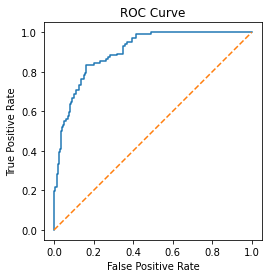

In [79]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum)
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [25]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum))
roc1 = roc_auc_score(ytestNum, predictionsNum)

ROC_AUC score:  0.9019854172824909


In [26]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum))
aucpr1 = average_precision_score(ytestNum, predictionsNum)

AUC-PR score:  0.7236805132569766


In [27]:
pipe2 = Pipeline(steps=[("Preprocessing", preprocessor), ("mlp", MLPClassifier())])
mlp_grid = {'mlp__hidden_layer_sizes': [(50,), (100,), (200,), (400,)],
               'mlp__activation': ['identity','logistic','tanh', 'relu'],
               'mlp__solver': ['sgd', 'adam'],
               'mlp__alpha': [0.01, 0.001, 0.0001, 0.00001],
               'mlp__learning_rate': ['constant', 'invscaling', 'adaptive'],
               'mlp__learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
               'mlp__early_stopping': [True],
               'mlp__max_iter': [200, 2000, 20000, 200000]}
mlpSearch = RandomizedSearchCV(pipe2, param_distributions = mlp_grid, n_iter=10, cv=5, scoring='accuracy', refit='accuracy', random_state=301)

mlpSearch.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['LBXWBCSI',
                                                                                'LBXLYPCT',
                                                                                'LBXMOPCT',
                                                                                'LBXEOPCT',
                                                                                'LBXBAPCT',
                                                                                'LBDMONO',
                                                                                'LBDNENO',
                                                                                'LBDEONO',
                                                                                'LBXRBCSI',
                                                                                'LBXMCVSI',
                                                                                'LBXMC',
                                                                                'LBXRDW',
                                                                                'LBXPLTSI',
                                                                                'LBXMPSI',
                                                                                'LBXBPB',...
                                        'mlp__alpha': [0.01, 0.001, 0.0001,
                                                       1e-05],
                                        'mlp__early_stopping': [True],
                                        'mlp__hidden_layer_sizes': [(50,),
                                                                    (100,),
                                                                    (200,),
                                                                    (400,)],
                                        'mlp__learning_rate': ['constant',
                                                               'invscaling',
                                                               'adaptive'],
                                        'mlp__learning_rate_init': [0.0001,
                                                                    0.001, 0.01,
                                                                    0.1],
                                        'mlp__max_iter': [200, 2000, 20000,
                                                          200000],
                                        'mlp__solver': ['sgd', 'adam']},
                   random_state=301, refit='accuracy', scoring='accuracy')

In [28]:
mlpSearch.best_score_ 

0.8414999999999999

In [29]:
predictions2 = mlpSearch.best_estimator_.predict(xtest)

In [30]:
accuracy_score(ytest, predictions2)

0.852

In [31]:
print(classification_report(ytest, predictions2))

              precision    recall  f1-score   support

       False       0.89      0.92      0.91       398
        True       0.66      0.57      0.61       102

    accuracy                           0.85       500
   macro avg       0.78      0.75      0.76       500
weighted avg       0.85      0.85      0.85       500



In [32]:
predictionsNum2 = mlpSearch.best_estimator_.predict_proba(xtest)[:, 1]

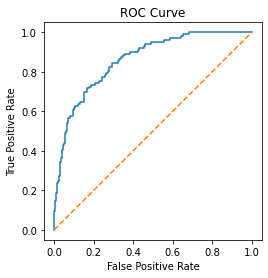

In [78]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum2)
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [34]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum2))
roc2 = roc_auc_score(ytestNum, predictionsNum2)

ROC_AUC score:  0.8604049660065031


In [35]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum2))
aucpr2 = average_precision_score(ytestNum, predictionsNum2)

AUC-PR score:  0.6457278139583513


In [36]:
pipe3 = Pipeline(steps=[("Preprocessing", preprocessor), ("gbc", GradientBoostingClassifier())])
grad_grid = {'gbc__loss': ['log_loss', 'exponential'],
               'gbc__learning_rate': [0.2, 0.1, 0.01, 0.001, 0.0001],
               'gbc__n_estimators': [20, 50, 100, 200, 400],
               'gbc__criterion': ['friedman_mse', 'squared_error'],
               'gbc__max_depth': [2,3,4,5],
               'gbc__min_samples_split': [2, 5, 10,20],
               'gbc__min_samples_leaf': [1, 2]}
gradSearch = RandomizedSearchCV(pipe3, param_distributions = grad_grid,n_iter=10, cv=10, scoring='accuracy', refit='accuracy',random_state=301)

gradSearch.fit(xtrain, ytrain)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['LBXWBCSI',
                                                                                'LBXLYPCT',
                                                                                'LBXMOPCT',
                                                                                'LBXEOPCT',
                                                                                'LBXBAPCT',
                                                                                'LBDMONO',
                                                                                'LBDNENO',
                                                                                'LBDEONO',
                                                                                'LBXRBCSI',
                                                                                'LBXMCVSI',
                                                                                'LBXMC',
                                                                                'LBXRDW',
                                                                                'LBXPLTSI',
                                                                                'LBXMPSI',
                                                                                'LBXBPB'...
                                              GradientBoostingClassifier())]),
                   param_distributions={'gbc__criterion': ['friedman_mse',
                                                           'squared_error'],
                                        'gbc__learning_rate': [0.2, 0.1, 0.01,
                                                               0.001, 0.0001],
                                        'gbc__loss': ['log_loss',
                                                      'exponential'],
                                        'gbc__max_depth': [2, 3, 4, 5],
                                        'gbc__min_samples_leaf': [1, 2],
                                        'gbc__min_samples_split': [2, 5, 10,
                                                                   20],
                                        'gbc__n_estimators': [20, 50, 100, 200,
                                                              400]},
                   random_state=301, refit='accuracy', scoring='accuracy')

In [37]:
gradSearch.best_score_

0.897

In [38]:
predictions3 = gradSearch.best_estimator_.predict(xtest)

In [39]:
accuracy_score(ytest, predictions3)

0.878

In [40]:
print(classification_report(ytest, predictions3))

              precision    recall  f1-score   support

       False       0.89      0.97      0.93       398
        True       0.82      0.52      0.63       102

    accuracy                           0.88       500
   macro avg       0.85      0.74      0.78       500
weighted avg       0.87      0.88      0.87       500



In [41]:
predictionsNum3 = gradSearch.best_estimator_.predict_proba(xtest)[:, 1]

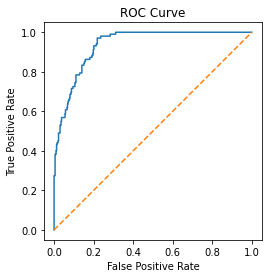

In [77]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum3)
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [43]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum3))
roc3 = roc_auc_score(ytestNum, predictionsNum3)

ROC_AUC score:  0.935806483397379


In [44]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum3))
aucpr3 = average_precision_score(ytestNum, predictionsNum3)

AUC-PR score:  0.7997761748124788


## Demographic/environmental dataset

In [45]:
#newdataset variables:
catVars, numVars = catNamesAndNumNames(combinedLabDataImputed.drop(['SEQN','LBXHGB','DMDHRGND'], axis=1))
xtrain, xtest, ytrain, ytest = train_test_split(combinedLabDataImputed.drop(['SEQN','LBXHGB','DMDHRGND'], axis=1), anemiaDemoEnv, test_size=0.2, random_state=42)
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent"))]
)
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler(with_mean=False))]
)
preprocessor = ColumnTransformer( 
    transformers=[
        ("num", numeric_transformer, numVars),
        ("cat", categorical_transformer, catVars)]
)

# 10% of the total variables will be selected
selection = SelectPercentile(chi2, percentile = 10)
pipe4 = Pipeline(
    steps = [("preprocessor", preprocessor),  ("rfc", RandomForestClassifier())]
)

random_grid = {'rfc__n_estimators': [200, 400, 600, 800, 1000],
               'rfc__max_features': ['log2', 'sqrt'],
               'rfc__max_depth': [10, 20, 30, 40, 50, 100],
               'rfc__min_samples_split': [2, 5, 10, 20],
               'rfc__min_samples_leaf': [1, 2, 4, 6],
               'rfc__bootstrap': [True, False]}
randomSearch = RandomizedSearchCV(pipe4, param_distributions = random_grid, scoring='accuracy', refit='accuracy', n_iter=10, cv=5, random_state=301)

randomSearch.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['LBXWBCSI',
                                                                                'LBXLYPCT',
                                                                                'LBXMOPCT',
                                                                                'LBXEOPCT',
                                                                                'LBXBAPCT',
                                                                                'LBDMONO',
                                                                                'LBDNENO',
                                                                                'LBDEONO',
                                                                                'LBXRBCSI',
                                                                                'LBXMCVSI',
                                                                                'LBXMC',
                                                                                'LBXRDW',
                                                                                'LBXPLTSI',
                                                                                'LBXMPSI',
                                                                                'LBXBPB',
                                                                                '...
                                                                                'LBDVD3LC',
                                                                                'LBDVE3LC'])])),
                                             ('rfc',
                                              RandomForestClassifier())]),
                   param_distributions={'rfc__bootstrap': [True, False],
                                        'rfc__max_depth': [10, 20, 30, 40, 50,
                                                           100],
                                        'rfc__max_features': ['log2', 'sqrt'],
                                        'rfc__min_samples_leaf': [1, 2, 4, 6],
                                        'rfc__min_samples_split': [2, 5, 10,
                                                                   20],
                                        'rfc__n_estimators': [200, 400, 600,
                                                              800, 1000]},
                   random_state=301, refit='accuracy', scoring='accuracy')

In [46]:
randomSearch.best_score_ 

0.8799999999999999

In [47]:
predictions4 = randomSearch.best_estimator_.predict(xtest)

In [48]:
accuracy_score(ytest, predictions4)

0.856

In [49]:
print(classification_report(ytest, predictions4))

              precision    recall  f1-score   support

       False       0.86      0.97      0.91       398
        True       0.79      0.40      0.53       102

    accuracy                           0.86       500
   macro avg       0.83      0.69      0.72       500
weighted avg       0.85      0.86      0.84       500



In [50]:
predictionsNum4 = randomSearch.best_estimator_.predict_proba(xtest)[:, 1]

In [51]:
ytestNum = []
for i in ytest:
    if i =="True":
        ytestNum.append(1)
    elif i=="False":
        ytestNum.append(0)

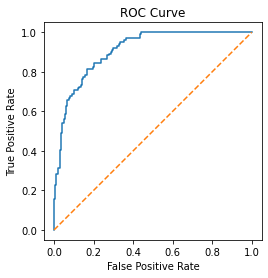

In [76]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum4)
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [53]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum4))
roc4 = roc_auc_score(ytestNum, predictionsNum4)

ROC_AUC score:  0.9079712286924821


In [54]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum4))
aucpr4 = average_precision_score(ytestNum, predictionsNum4)

AUC-PR score:  0.734720360029524


In [55]:
pipe5 = Pipeline(steps=[("Preprocessing", preprocessor), ("mlp", MLPClassifier())])
mlp_grid = {'mlp__hidden_layer_sizes': [(50,), (100,), (200,), (400,)],
               'mlp__activation': ['identity','logistic','tanh', 'relu'],
               'mlp__solver': ['sgd', 'adam'],
               'mlp__alpha': [0.01, 0.001, 0.0001, 0.00001],
               'mlp__learning_rate': ['constant', 'invscaling', 'adaptive'],
               'mlp__learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
               'mlp__early_stopping': [True],
               'mlp__max_iter': [200, 2000, 20000, 200000]}
mlpSearch = RandomizedSearchCV(pipe5, param_distributions = mlp_grid, n_iter=10, cv=5, scoring='accuracy', refit='accuracy', random_state=301)

mlpSearch.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['LBXWBCSI',
                                                                                'LBXLYPCT',
                                                                                'LBXMOPCT',
                                                                                'LBXEOPCT',
                                                                                'LBXBAPCT',
                                                                                'LBDMONO',
                                                                                'LBDNENO',
                                                                                'LBDEONO',
                                                                                'LBXRBCSI',
                                                                                'LBXMCVSI',
                                                                                'LBXMC',
                                                                                'LBXRDW',
                                                                                'LBXPLTSI',
                                                                                'LBXMPSI',
                                                                                'LBXBPB',...
                                        'mlp__alpha': [0.01, 0.001, 0.0001,
                                                       1e-05],
                                        'mlp__early_stopping': [True],
                                        'mlp__hidden_layer_sizes': [(50,),
                                                                    (100,),
                                                                    (200,),
                                                                    (400,)],
                                        'mlp__learning_rate': ['constant',
                                                               'invscaling',
                                                               'adaptive'],
                                        'mlp__learning_rate_init': [0.0001,
                                                                    0.001, 0.01,
                                                                    0.1],
                                        'mlp__max_iter': [200, 2000, 20000,
                                                          200000],
                                        'mlp__solver': ['sgd', 'adam']},
                   random_state=301, refit='accuracy', scoring='accuracy')

In [56]:
mlpSearch.best_score_

0.8554999999999999

In [57]:
predictions5 = mlpSearch.best_estimator_.predict(xtest)

In [58]:
accuracy_score(ytest, predictions5)

0.838

In [59]:
print(classification_report(ytest, predictions5))

              precision    recall  f1-score   support

       False       0.87      0.94      0.90       398
        True       0.66      0.43      0.52       102

    accuracy                           0.84       500
   macro avg       0.76      0.69      0.71       500
weighted avg       0.82      0.84      0.82       500



In [60]:
predictionsNum5 = randomSearch.best_estimator_.predict_proba(xtest)[:, 1]

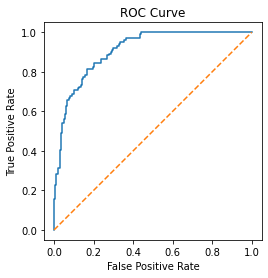

In [75]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum5)
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [62]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum5))
roc5 = roc_auc_score(ytestNum, predictionsNum5)

ROC_AUC score:  0.9079712286924821


In [63]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum5))
aucpr5 = average_precision_score(ytestNum, predictionsNum5)

AUC-PR score:  0.734720360029524


In [64]:
pipe6 = Pipeline(steps=[("Preprocessing", preprocessor), ("gbc", GradientBoostingClassifier())])
grad_grid = {'gbc__loss': ['log_loss', 'exponential'],
               'gbc__learning_rate': [0.2, 0.1, 0.01, 0.001, 0.0001],
               'gbc__n_estimators': [20, 50, 100, 200, 400],
               'gbc__criterion': ['friedman_mse', 'squared_error'],
               'gbc__max_depth': [2,3,4,5],
               'gbc__min_samples_split': [2, 5, 10,20],
               'gbc__min_samples_leaf': [1, 2]}
gradSearch = RandomizedSearchCV(pipe6, param_distributions = grad_grid,n_iter=10, cv=10, scoring='accuracy', refit='accuracy',random_state=301)

gradSearch.fit(xtrain, ytrain)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['LBXWBCSI',
                                                                                'LBXLYPCT',
                                                                                'LBXMOPCT',
                                                                                'LBXEOPCT',
                                                                                'LBXBAPCT',
                                                                                'LBDMONO',
                                                                                'LBDNENO',
                                                                                'LBDEONO',
                                                                                'LBXRBCSI',
                                                                                'LBXMCVSI',
                                                                                'LBXMC',
                                                                                'LBXRDW',
                                                                                'LBXPLTSI',
                                                                                'LBXMPSI',
                                                                                'LBXBPB'...
                                              GradientBoostingClassifier())]),
                   param_distributions={'gbc__criterion': ['friedman_mse',
                                                           'squared_error'],
                                        'gbc__learning_rate': [0.2, 0.1, 0.01,
                                                               0.001, 0.0001],
                                        'gbc__loss': ['log_loss',
                                                      'exponential'],
                                        'gbc__max_depth': [2, 3, 4, 5],
                                        'gbc__min_samples_leaf': [1, 2],
                                        'gbc__min_samples_split': [2, 5, 10,
                                                                   20],
                                        'gbc__n_estimators': [20, 50, 100, 200,
                                                              400]},
                   random_state=301, refit='accuracy', scoring='accuracy')

In [65]:
gradSearch.best_score_

0.897

In [66]:
predictions6 = gradSearch.best_estimator_.predict(xtest)

In [67]:
accuracy_score(ytest, predictions6)

0.878

In [68]:
print(classification_report(ytest, predictions6))

              precision    recall  f1-score   support

       False       0.89      0.97      0.93       398
        True       0.82      0.52      0.63       102

    accuracy                           0.88       500
   macro avg       0.85      0.74      0.78       500
weighted avg       0.87      0.88      0.87       500



In [69]:
predictionsNum6 = gradSearch.best_estimator_.predict_proba(xtest)[:, 1]

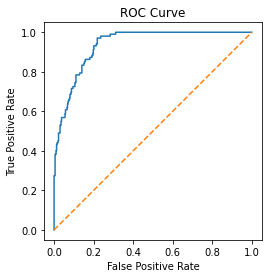

In [74]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum6)
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [71]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum6))
roc6 = roc_auc_score(ytestNum, predictionsNum6)

ROC_AUC score:  0.935806483397379


In [72]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum6))
aucpr6 = average_precision_score(ytestNum, predictionsNum6)

AUC-PR score:  0.7997761748124788


## Combined dataset

In [80]:
#newdataset variables:
catVars, numVars = catNamesAndNumNames(newDataset.drop(['SEQN','LBXHGB','DMDHRGND'], axis=1))
xtrain, xtest, ytrain, ytest = train_test_split(newDataset.drop(['SEQN','LBXHGB','DMDHRGND'], axis=1), anemia, test_size=0.2, random_state=42)
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent"))]
)
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler(with_mean=False))]
)
preprocessor = ColumnTransformer( 
    transformers=[
        ("num", numeric_transformer, numVars),
        ("cat", categorical_transformer, catVars)]
)

# 10% of the total variables will be selected
selection = SelectPercentile(chi2, percentile = 10)
pipe7 = Pipeline(
    steps = [("preprocessor", preprocessor),  ("rfc", RandomForestClassifier())]
)

random_grid = {'rfc__n_estimators': [200, 400, 600, 800, 1000],
               'rfc__max_features': ['log2', 'sqrt'],
               'rfc__max_depth': [10, 20, 30, 40, 50, 100],
               'rfc__min_samples_split': [2, 5, 10, 20],
               'rfc__min_samples_leaf': [1, 2, 4, 6],
               'rfc__bootstrap': [True, False]}
randomSearch = RandomizedSearchCV(pipe7, param_distributions = random_grid, scoring='accuracy', refit='accuracy', n_iter=10, cv=5, random_state=301)

randomSearch.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['LBXWBCSI_x',
                                                                                'LBXLYPCT_x',
                                                                                'LBXMOPCT_x',
                                                                                'LBXEOPCT_x',
                                                                                'LBXBAPCT_x',
                                                                                'LBDMONO_x',
                                                                                'LBDNENO_x',
                                                                                'LBDEONO_x',
                                                                                'LBXRBCSI_x',
                                                                                'LBXMCVSI_x',
                                                                                'LBXMC_x',
                                                                                'LBXRDW_x',
                                                                                'LBXPLT...
                                                                                'MCQ160L',
                                                                                'MCQ160O', ...])])),
                                             ('rfc',
                                              RandomForestClassifier())]),
                   param_distributions={'rfc__bootstrap': [True, False],
                                        'rfc__max_depth': [10, 20, 30, 40, 50,
                                                           100],
                                        'rfc__max_features': ['log2', 'sqrt'],
                                        'rfc__min_samples_leaf': [1, 2, 4, 6],
                                        'rfc__min_samples_split': [2, 5, 10,
                                                                   20],
                                        'rfc__n_estimators': [200, 400, 600,
                                                              800, 1000]},
                   random_state=301, refit='accuracy', scoring='accuracy')

In [81]:
randomSearch.best_score_ 

0.869

In [82]:
predictions7 = randomSearch.best_estimator_.predict(xtest)

In [83]:
ytestNum = []
for i in ytest:
    if i =="True":
        ytestNum.append(1)
    elif i=="False":
        ytestNum.append(0)

In [84]:
accuracy_score(ytest, predictions7)

0.842

In [85]:
print(classification_report(ytest, predictions7))

              precision    recall  f1-score   support

       False       0.85      0.98      0.91       398
        True       0.78      0.31      0.45       102

    accuracy                           0.84       500
   macro avg       0.81      0.65      0.68       500
weighted avg       0.83      0.84      0.81       500



In [86]:
predictionsNum7 = randomSearch.best_estimator_.predict_proba(xtest)[:, 1]

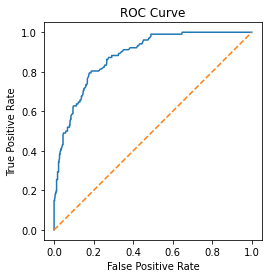

In [87]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum7)
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
ax.set_aspect('equal', adjustable='box')

In [88]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum7))
roc7 = roc_auc_score(ytestNum, predictionsNum7)

ROC_AUC score:  0.8814538378165336


In [89]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum7))
aucpr7 = average_precision_score(ytestNum, predictionsNum7)

AUC-PR score:  0.6802721053767151


In [97]:
pipe8 = Pipeline(steps=[("Preprocessing", preprocessor), ("mlp", MLPClassifier())])
mlp_grid = {'mlp__hidden_layer_sizes': [(50,), (100,), (200,), (400,)],
               'mlp__activation': ['identity','logistic','tanh', 'relu'],
               'mlp__solver': ['sgd', 'adam'],
               'mlp__alpha': [0.01, 0.001, 0.0001, 0.00001],
               'mlp__learning_rate': ['constant', 'invscaling', 'adaptive'],
               'mlp__learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
               'mlp__early_stopping': [True],
               'mlp__max_iter': [200, 2000, 20000, 200000]}
mlpSearch = RandomizedSearchCV(pipe8, param_distributions = mlp_grid, n_iter=10, cv=5, scoring='accuracy', refit='accuracy', random_state=301)

mlpSearch.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['LBXWBCSI_x',
                                                                                'LBXLYPCT_x',
                                                                                'LBXMOPCT_x',
                                                                                'LBXEOPCT_x',
                                                                                'LBXBAPCT_x',
                                                                                'LBDMONO_x',
                                                                                'LBDNENO_x',
                                                                                'LBDEONO_x',
                                                                                'LBXRBCSI_x',
                                                                                'LBXMCVSI_x',
                                                                                'LBXMC_x',
                                                                                'LBXRDW_x',
                                                                                'LBXPL...
                                        'mlp__alpha': [0.01, 0.001, 0.0001,
                                                       1e-05],
                                        'mlp__early_stopping': [True],
                                        'mlp__hidden_layer_sizes': [(50,),
                                                                    (100,),
                                                                    (200,),
                                                                    (400,)],
                                        'mlp__learning_rate': ['constant',
                                                               'invscaling',
                                                               'adaptive'],
                                        'mlp__learning_rate_init': [0.0001,
                                                                    0.001, 0.01,
                                                                    0.1],
                                        'mlp__max_iter': [200, 2000, 20000,
                                                          200000],
                                        'mlp__solver': ['sgd', 'adam']},
                   random_state=301, refit='accuracy', scoring='accuracy')

In [98]:
mlpSearch.best_score_

0.805

In [99]:
predictions8 = mlpSearch.best_estimator_.predict(xtest)

In [100]:
accuracy_score(ytest, predictions8)

0.796

In [101]:
print(classification_report(ytest, predictions8))

              precision    recall  f1-score   support

       False       0.80      1.00      0.89       398
        True       0.00      0.00      0.00       102

    accuracy                           0.80       500
   macro avg       0.40      0.50      0.44       500
weighted avg       0.63      0.80      0.71       500



c:\Users\dl668\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dl668\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dl668\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [95]:
predictionsNum8 = mlpSearch.best_estimator_.predict_proba(xtest)[:, 1]

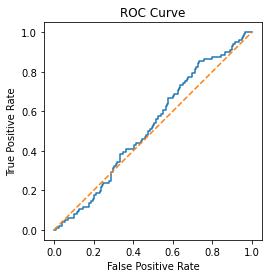

In [96]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum8)
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
ax.set_aspect('equal', adjustable='box')

In [104]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum8))
roc8 = roc_auc_score(ytestNum, predictionsNum8)

ROC_AUC score:  0.5249778303281111


In [105]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum8))
aucpr8 = average_precision_score(ytestNum, predictionsNum8)

AUC-PR score:  0.20747496181132896


In [106]:
pipe9 = Pipeline(steps=[("Preprocessing", preprocessor), ("gbc", GradientBoostingClassifier())])
grad_grid = {'gbc__loss': ['log_loss', 'exponential'],
               'gbc__learning_rate': [0.2, 0.1, 0.01, 0.001, 0.0001],
               'gbc__n_estimators': [20, 50, 100, 200, 400],
               'gbc__criterion': ['friedman_mse', 'squared_error'],
               'gbc__max_depth': [2,3,4,5],
               'gbc__min_samples_split': [2, 5, 10,20],
               'gbc__min_samples_leaf': [1, 2]}
gradSearch = RandomizedSearchCV(pipe9, param_distributions = grad_grid,n_iter=10, cv=10, scoring='accuracy', refit='accuracy',random_state=301)

gradSearch.fit(xtrain, ytrain)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['LBXWBCSI_x',
                                                                                'LBXLYPCT_x',
                                                                                'LBXMOPCT_x',
                                                                                'LBXEOPCT_x',
                                                                                'LBXBAPCT_x',
                                                                                'LBDMONO_x',
                                                                                'LBDNENO_x',
                                                                                'LBDEONO_x',
                                                                                'LBXRBCSI_x',
                                                                                'LBXMCVSI_x',
                                                                                'LBXMC_x',
                                                                                'LBXRDW_x',
                                                                                'LBXP...
                                              GradientBoostingClassifier())]),
                   param_distributions={'gbc__criterion': ['friedman_mse',
                                                           'squared_error'],
                                        'gbc__learning_rate': [0.2, 0.1, 0.01,
                                                               0.001, 0.0001],
                                        'gbc__loss': ['log_loss',
                                                      'exponential'],
                                        'gbc__max_depth': [2, 3, 4, 5],
                                        'gbc__min_samples_leaf': [1, 2],
                                        'gbc__min_samples_split': [2, 5, 10,
                                                                   20],
                                        'gbc__n_estimators': [20, 50, 100, 200,
                                                              400]},
                   random_state=301, refit='accuracy', scoring='accuracy')

In [107]:
gradSearch.best_score_

0.8985

In [108]:
predictions9 = gradSearch.best_estimator_.predict(xtest)

In [109]:
accuracy_score(ytest, predictions9)

0.878

In [110]:
print(classification_report(ytest, predictions9))

              precision    recall  f1-score   support

       False       0.90      0.95      0.93       398
        True       0.76      0.59      0.66       102

    accuracy                           0.88       500
   macro avg       0.83      0.77      0.79       500
weighted avg       0.87      0.88      0.87       500



In [111]:
predictionsNum9 = gradSearch.best_estimator_.predict_proba(xtest)[:, 1]

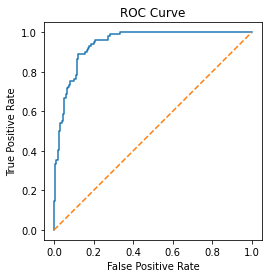

In [112]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum9)
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [113]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum9))
roc9 = roc_auc_score(ytestNum, predictionsNum9)

ROC_AUC score:  0.9431224751207015


In [114]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum9))
aucpr9 = average_precision_score(ytestNum, predictionsNum9)

AUC-PR score:  0.8069072906252404
